In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [5]:
try:
    from duckduckgo_search import ddg_images
except ImportError:
    !pip install -Uqq duckduckgo_search
    from duckduckgo_search import ddg_images

from fastcore.all import *

In [6]:
def search_images(term, max_images=200): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
urls = search_images("horse paint", max_images=1)

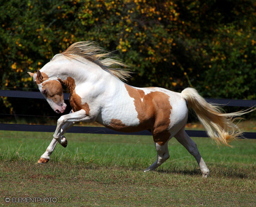

In [8]:
from fastdownload import download_url
dest = 'horse_paint.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


In [12]:
horse_colors = [
    'paint',
    'blood bay', 
    'dark bay', 
    'flaxen chestnut', 
    'liver chestnut', 
    'black', 
    'fleabitten gray', 
    'dapply gray',
    'dun',
    'buttermilk buckskin'
]

In [13]:
searches = horse_colors
path = Path('horse_classifier')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} horse photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
#     download_images(dest, urls=search_images(f'{o} sun photo'))
#     sleep(10)
#     download_images(dest, urls=search_images(f'{o} shade photo'))
#     sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

35

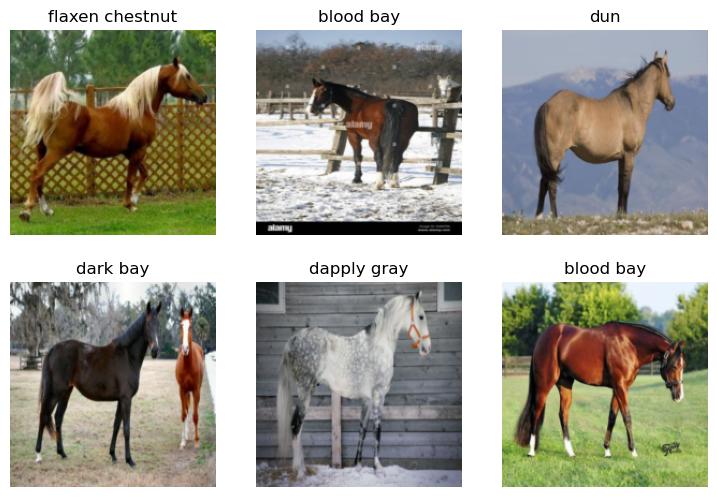

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
download_url("https://i.pinimg.com/originals/3b/66/53/3b6653c43c57b878bbcbd12d1e7292a1.jpg",
            "horse_blood_bay.jpg")

Path('horse_blood_bay.jpg')

In [19]:
cat,index,probs = learn.predict(PILImage.create('horse_blood_bay.jpg'))
print(f"This is a: {cat}.")
print(f"Probability it's a bird: {probs[index]:.4f}")

This is a: blood bay.
Probability it's a bird: 0.9412


In [21]:
import os
os.path.splitext("https://i.pinimg.com/originals/3b/66/53/3b6653c43c57b878bbcbd12d1e7292a1.jpg")

('https://i.pinimg.com/originals/3b/66/53/3b6653c43c57b878bbcbd12d1e7292a1',
 '.jpg')

In [26]:
def predict(url):
    temp_img = "predict_temp" + os.path.splitext(url)[1]
    download_url(url, temp_img)
    im = PILImage.create(temp_img)
    cat,index,probs = learn.predict(im)
    display(im)
    print(f"This is a: {cat}.")
    print(f"Probability it's a {cat}: {probs[index]:.4f}")

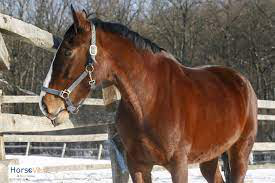

This is a: blood bay.
Probability it's a blood bay: 0.9852


In [27]:
predict("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMqE5YWipt3JUpMGLNyITqA1MOmxEXDWFARCAaERomS5cMXmsgsgttX5U_c1lVbohR6vo&usqp=CAU")

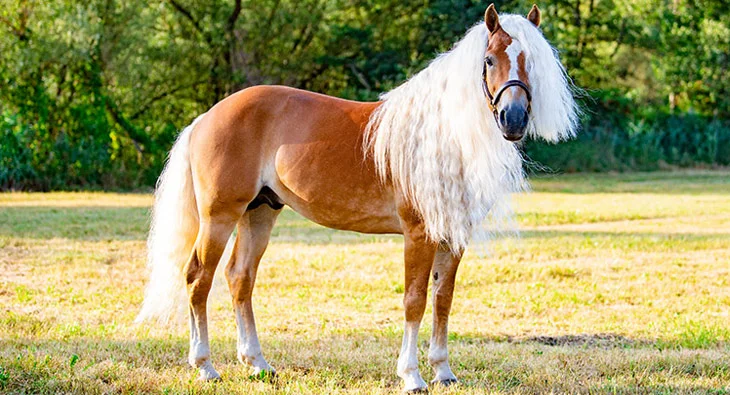

This is a: flaxen chestnut.
Probability it's a flaxen chestnut: 0.9528


In [28]:
predict("https://www.cavalluna.com/fileadmin/Entdecken/Pferdewissen/Pferderassen/Haflinger/haflinger_kachel.jpg")

In [29]:
predict("https://shoestringstable.files.wordpress.com/2013/04/4_buttermilk-buckskin.jpg
        ")

SyntaxError: EOL while scanning string literal (3825514128.py, line 1)

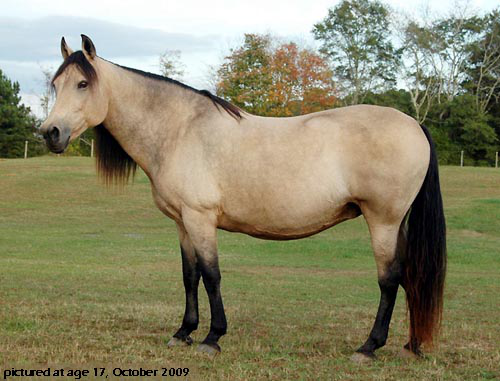

This is a: buttermilk buckskin.
Probability it's a buttermilk buckskin: 0.8990


In [30]:
predict("https://shoestringstable.files.wordpress.com/2013/04/4_buttermilk-buckskin.jpg")

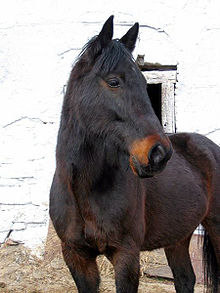

This is a: dark bay.
Probability it's a dark bay: 0.9433


In [31]:
predict("https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Kevin_Tornado_Zlosyn_2005.jpg/220px-Kevin_Tornado_Zlosyn_2005.jpg")

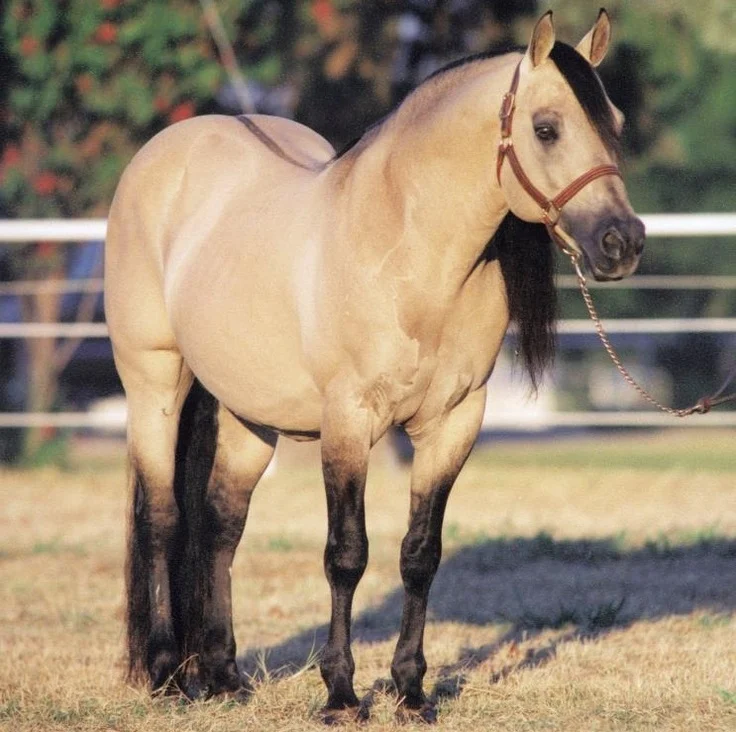

This is a: dun.
Probability it's a dun: 0.9587


In [32]:
predict("https://www.doubledtrailers.com/assets/images/Content-Images/dun-horses/Pictures-of-Dun-Horses.jpg")

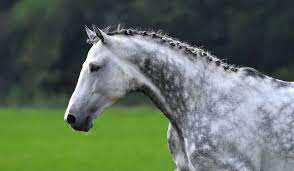

This is a: dapply gray.
Probability it's a dapply gray: 0.9976


In [33]:
predict("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgVFRUYGBgZGBgVGBgYGRgYGBgYGRkZGRgYGBgcIS4lHB4rHxgYJjgmKy8xNTU1HCQ7QDs0Py40NTEBDAwMEA8QGBISGjEhGCE0MTQ0NDE0NDQ0NDE0MTE0MTExNDQxMTQ0NDQ0NDUxNjQxNDQ0ND4xQDQ0MTQxN0A/Mf/AABEIAKsBJgMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAACAAEDBAUGBwj/xAA6EAABAwMCBAQEBQMEAQUAAAABAAIRAwQhEjEFQVFhInGBkQYyofATQrHB0QcU4SNikvFyFRYzgsL/xAAaAQEBAQEBAQEAAAAAAAAAAAAAAQIDBAUG/8QAIBEBAQEBAAIDAQEBAQAAAAAAAAERAgMSITFRQQQyE//aAAwDAQACEQMRAD8A85cpLejJUwoK5bshW34YHRtwFPMI2KGo9cLtrH2LWh1qs96THZWpyYtFyr1Ho31FC5y1zGohe9R6kT1Xc5dFTOUZRUzKd7UwRlyYPSAUzaKoTWShNNSkQoiCVBJSYFcBCoNUgqLNgmqKAhGXIVQwTshA5pRU2Qgd7VEcKd7gotYKREDihY6FM9irlVUjnqMuQgogqEAUlOyE2iVkA0pSjNNMGpoHKQRuICjJVQnlIJQiDEUySNJBfaFI10KJrkLnws0q0ayiqPVU1UH4sqeqRPqRB8KJiZyqjL00qMFOXK4GqOVZxROMoHFUOx8KQvlWeCW4q1PwzHja4DaZA1YJ2MAx+4wdZvA6lAubUZLHsLmVG+JjtOSJE6XadXhOZHTKo55pWhROFPb8Ee9r3sLSGH/UEwWNyQ8g7sIEyNiCDtJt1rRlKnJlz3GByAgAk/WPScbEuMx7JwoXyOXb79j7LoeAWbjUDyyA1r3NBG7g3wGDncg+irX3CHSxhqUxUeQNBf4tbsNaT8s7DfcqGMNrkiVpngh8WmoxxYdLxq06XZEEOAO432PZRVeE1BOljzBAkNJBnMyB00+6IptKMvAROsHgkFrgRAgtIMmIERvn6FRmzeX6IkyfYbnygTKmGCbVCGtV6IKlEtMGPQyPQ81E4pgTnpMKBNKokc5AQnlOAgFjEnNRtScVQqamaoqblOSshnOUJck5yEhJAL3ImBNCJiqJNKRKTkIUEbikkUlVW3PULnShJRhqACpabFG0ZV2mxZtQAbhAVK4QooUimDUqjcImtUdyVdFZzsqJ7kzymC2LNg97ajHM+dr2uZ/5AgtHfPJeqN4w/S3TR1MfEUy0hxe4EOa4/l0lrpPQjdeU2l06m9r2fM06hO0jaV6F8A0q1894OsU2NJc/W6DUeB4D1mA6PygGZ1BT6WMW2r1uH12PI1U5LS6SfA4/I/HzNOQefLddle/D9K7cHsuH0TsWsgsk7w3cT5+i1PivgNI2v9swbFr9R+Zzx+Zx5nPlyXM2D61J0Py6dwI+iRW3Q/p7TgONao94katek+0eSzeI/wBOtUOpvc1zTqBDsgjaCR1C6Jt46AQ7P06hX6PEMQ5wj7lWT5HCW3wG4vLnPLtR8bYa0znxAtAG5PJaN98MljAKdWqHNnSC44JaRuIPM8/0XUV7iMsOd0FtxgP8L258t/2WsTXB8N4I+3ZGtrxMw9gcRJGqJwTgbyqDH3LnvNah+IHYafCxzWAzpIZAcPPovUqlpTfmACQsjifBObHkGeXPEfop6muN/wDQ2V2OqhxY55LWseWAtgloGgE6R4YEgCI6hc9xb4auKBBe0Q4mCCAN9tyOYxMrrG/DT2VPxHBzjkCC4YO5I2mB9FDa8QqUKwpMoNew+BxkueZMananaYAI2B59VMxXA1Kbm4cIQL0O8bbVX6LkMY8OdoNFkE02kEaoJB5cgY65WXxL4X1M/EtiajZcNLWvmegBGTGnpzUTHIhyfUpq/DazMOY6Z0kQZBmIjr5bKvUpObGqJImJBPrGyJg2PQvqCVEQm0FUT03qYuVdjEZKlBFBqTOcglARcpGlQo5QE56HUhQlAetJRpJglLlKw4UTWqZgQHTYrbGwo2QFKagKxaRG5CEnFCqJ2Qqd2pXVIVO4qykgruKTWpmhTNath6dIuIa0S4kNaOrjgD3X0bwfhjLG0ZRYPlHidze85c8+Z9hA5LyT+mXAXXF2yoWn8Kg4VHuIwXjNNgPM6od5NzuJ9i4jxagCWOdqc3dozHnCn9WRn3FMvgnAVG7sWHzGxUfFeNNglpH+3tHVZFhxFz3T6notqusZpwR/CeowHbfPurzdFRsc1lXtm8DBUvwGfXDd3xt5+oVQ3ZOW7n0959VicRqPbOoDbB/ZLhNySZLZA+aeXn15p7JjoLbjj2Q0gzy6LRtOIvqO8oJGc91527jJfWjEScgcuy6i0uzTcCCCIAOSSOcegSdGOxfcscBiDznZU+I8IY46g2CRgj+VlHjDXMIOCMjuJ2+i2RxEeBwMtIgjEtOMLX2jnbjhgZL9ILxgOIBMYwD07LlXMrMe57NQJdqe3DQ6YbhwEzj07r1evTY+YOeYP7LG4rwvW0OZAcOUYP8APNZvK6xeE8ZZUY+i0PdoYXFtQNe8mc+LTGJgbnyWFdWNrXfbt1Cm+qfFpYNGrXoDHaT4XeHoBDgumseGeImNLiCHRgSD13jdVuIcO0seGiHb6miCdzjus4rgOL8HfbvLS1xgAlwEtyTEEcsTKy9S9S4R+JoeLlgqUmBv4USXDTI1QdiQQMHMLk73h9vWc99uyqA0yWPLBq1OMaXZDRg4yUTHNygJU93ScwgOY5hLZh0zuRJkDoq0ogpQkpSmCpBtKkUTURcgdAU5KaUCITpQnTRI1Sschc2Eiglc9PTJUNMyrAas0OQmLSrFJiJ7wMLIy6skqJ9IhaBAVe4etSisxikBTNervCOHm4r0qDRmo9jDHJpPjd6N1H0VHtHwDQNpw2mXwHVCawEZh8aJ76A09tuS8z+Mruoy+qBgduXY56jM7L13jdUF2huzGwAOWFwvFKGp5diSck5KTldcvYXFxUE1HHSTgZmPMldRwdmmB+qpsty056/Ratk2FufCtQNLRLd/qtG1rh7TO4wVnhhgD1+yhp+BziDBI/zj0WbUwV3ZtfIgA/QrieMh9B/hB0u+YdIxj0XYXvFKYIkwSY8+coLmzZcMznGDzS5VeXW5Otz9JeMkk/l3GTzWobiIcHkyASOYxnHNFxXhFSiXBo8JwQMDSqBDYBEGM6SYPKQO+SsjTtqjnBzxsCAR2bnIC6Bly3Q0hxBxIJ5jI8uq5LhFbxuaTALgdzyOR99FqVboPqhjcCSAc5BwtSjsOH8Q1eIkSBBPPoFu21QPYD6/ZXC0tVJ8T+XPfn9IXTUOINaxvIHEnG2y1KmNOozSCSMdeY/lZt1TLnN0xiQ7y/lPcXRfAHLn19uyjtboF+oD8sEHrPI8zhVFh2mNIEEjI25KvY8FZSY91Ilj3jLhnyEHcdlqW9OYJGTnbIU9WiYxuMqYuvPba1rVCX3NJha1pboZAe9wMgmG4Bg42M+QWdT4RSua2iHscWuhujUxkEN8YBa7nIxsF6cy2By5smZ2lXDQaPGGjUBHQ+UrPrT4eXcY+ELegPE+s+BksYAPPIiP5XOv4TReD+DXOofkqBrT6uBx5x7L1HidB9clgJaeeZH3BWLd/Az2APY/VGY2IzyV9UeZVaDmHS4QRy/6UDl3/EfhyqIcGh7DEtGHCeukYKVz/T57mB9N4afzMq4ju14EOHaJUyjhWU5U4tcK/U4XVZqmm6G/M5o1Nb5ubIHqq34ix1aIQxJSSkpoTk7acp3MVuhTwtWpaptpQp2qSq1QudCzukqQvgKhWeZWgxshV61BSUVDUKgc4lWzQkJqdsVrYqoAV6F/STh2u5fcOHhoMJB/31AWNH/HX9Fw76JB2XunwlwQ2Vm2m7/5Hn8Wr/tc4ABn/wBWgDznqtT5XUlRnzvO5MBc2KeqoSdm+LzO8LoOLXQA0gjuuZqVXSWsblwOSdhtMRzW78IrOqgkk7lXLOoR0/dYVwx7DLvorFlVneVjWnQsrHKr3dYzvBx9/qoWATJccbLH4/e6W4fJxEKaBuX/ADkkCC6B65PvPsht/ib8Fm4MYxmfJcy+5qkk6oBERvj7yqLrV+Yfk5z94UNek2XFqN23Q7DyI9Vy3GuDuovAI8M4d0kznr/hc/Y1nMeCMOGfXqF3lhxNtyzRUgkCJ6nY5V3RyVK0LqjmNPIkHynPr+4V7hjy0h52Y7SZ3zzAmdwq9S20PIJLYkA9ht9E7rRwa0l3z5nEGPXrCsG++8a97HEgAjzzMT991u3BaWhgzG3P/tctRtQHsEglwDx9SukvKOgMIyHAZBmP55qi1SugyWHPIEdxv2Q8PoGSWkzJjoZ3T+EgEmI3nsitn6SOTTG2+8BWVlu21VwI1YkfutNjwRk9QudGp7jB2x9ypn3JYADPL374Wx0Je0Dss24raT4TOcwqj7sObAPYkcj0P0QUgY6oLArHcAh3MH2x7K3TvgGwZk7z1VaiAd56Z+qnFqDg+nkgKlTaXSR/Ckr0DoLZkR9FBQlhjcK4KhIVxHKV7cUPHTLmvMTpkTvust9o6q//AFrdryTGt1NoeRtOsAH9V3T7VsyRM52Vh7mADwphrlLH4ZswP9S1aSZIzWGJ6a4SXaU7sQIASWMn4uvn5jMqwGK8eHqX+0heK+Xn9Z2MWqxA6lK2P7KSj/sFr/05/U1nUKWEqlBaX9qQk62U95+msoUYTspBXTalL+1Kvvz+rrS+BeDtuL1kiW05rOHXQRoH/Mt9AV6Lxi8IcQDmfEZXP/C1MWVpUuXGH1nCmzqGt1ZHrq/4hZlTiQh3OciT9TK9Hj+tbn0kv73xEkgwDjcqt/fBrZO55fysd9zMud5x5LLueJEujP3yWrTG7/cajqPomFN3zD/CGwpkjU/GJjb7KsVqjnCMAcoXLvvnn7Nxk3d28GAc9uXtss2q9zvmMrc/swgPDgVxnk5/UvWsIlE1kraZwwKQWLQrfLymxzte01CNjyPQqOwujTeBsRv3jYLpH2gWfe8ILxLYDhtOx7FXnySrOou8QqsrUmuGXAie42KqW1MOls4AOkH3EdMKvwavofoeCM6Xdjtsrl/Rcx50jUHZGem/6rtrSsxxb4jPhdsOQn/K63hpNWHPONJDRtjy8v1WBSohoBeZbUaeuHbQY5bFa/w3XDSGmTBgTkEbCD6qwaZtoGg75d1xnGFae0BrdgMA9FVfdl1QkDBaIwdwSSM/eFJVfLNLeUn791qRlbt7rQXHYTHLJ3TXjHPOo4HoSs6zeHzqJ8JHh3OOcrpbN7SM5meWB2Wxj0rYsbnIJzgH1++ytsrxBOZwMHc9fZWKtwJ+XPacgT6ILFgfyIbtnc/z/hBJQ1EyQQtRkYUJbgbYQGoAJKIsVnMhRUKwGTMHpssOveO1wZDATkTOeoWnbXbHN7d/26q6Y1qVWRhB/dMEh0AgdlRqVCwagcRt/CzKbH1TqMgTgTuPuU0xsNucnRkeUhMqjq/4AgRBOJ/RJUxxMpijhOGr837OCKETVIGJ9KvtRGUJCnAQwpO6IdKRapoTq+9A/wBTfiE0P7e1oFhaykHPBbqBdJbHYjQ7v4vfmrPjAqskthzTDgNvMK58QcFFaXgnU1pMb6gJJAPv9lcpbvFOWg85M/ovr+Ly89cyx6ObLGzcXYYCTnGwU3C26/FpyMxE79YXPVKpf7rq/h58S0D8oJPQzgfQrfffrzevw6uRtAYE+cd0xapAZShfH78vXd2uN6tRFiQYVKiAWPepqLQVGWFWkMJ71ELaaIU4UieE96Mbi/DnVBqZh4ERgBw6T16FZ/DOIuGH7tnBweQI/wALqA1ZPxvwk0nMez8zGl4/36RP35r3/wCTyddbL/Hbx9W/AGnUS1nyyCJnmQt7hNFpY5s85ERtv6Y/Vc5wrxgPnDsOH7fVdHYPaydWZbj2PNe/lutB9q0B8wSILfKCrNCwLmF0QfPMbKhbuY5hc4y7BbJjwyJz7K5TvWNYG6iTyjbPXtldEVH2+YB7E45ZGyvWzntG3YE5xjP6q5w63D2kwMmdvdWXvbT8P395QVLFkHIBJ57bzt1VkDTMEYMR9+6F8Oy3ce8qk+q6YdBa7M9OiDQo1vZPXZjZU2YILcjn0Uz6ocCOaCrcMa0O1TB6LKtroB+QQBMA4E42U11dOGA7O/X75rMe4ueC4bnz6mQFB0Dbs1BGe3lzVs09OnTvyEqK2YdAGIjBO/tCcvdEggkcttlRTv6bpBfnGwkQUlGawqOP4pdI2AMR7pJowgilPCaF+a15y1J9SbSiDVNClJGGJtCaBTQi0og1XQLSsziXA6NZxeWlrjuWGJPUjZasJaVrnydc/wDNxZ1Z9Oe/9o0zGmq5sZ8QB88yFuUbVjGhjdgI7+fmpixAWLXXn76mdVb1b9hlOkGIi1c9ZCnDk+hIMTQ0pFFpTwpojJTAoyEgE0Hbs1Pa07Oc1p8iQFb4o38au9jzsBjsdx6AgqpRMOaRuCCPMFUKPEiapc4eJz8zj5cEdxEL6X+HMrr4/wCsvhVM0Lo092kkR2cCAR6kLqRbsc1gHMkH73lYXG6M1A9mDvjGQZC7C5t2MFN7ARraHRvknb6hfQ5dKpOthlkkuDsAbYI3g90127S0MczSQ0EEjfzjyTVbgsrB7/CQJON94jpzWfdXL6jzokh04k6d8b5kLaOm4Zdtps0zk52gDCjubrWZBzgwD1xJWVwch4LTgxk5PrnyRuLQ4kfl7po1WUSRJJA55j9FY/DABHsVm074DB88+akp1w+c8oGY37Jou0X7gclUuQ5viHP6KyaYgEYP3/hU31OQO2YHbdUROY0zPzTOe4/7WfcUw3YgnbuVo1XB4PKBAWYGzuDO052lY0XLfiWQyMEE/wCE9MvyRME6Y39lDc0GANjlnyClp1xoMOOobAcvMKixbsLCQ9oJOcDHdJVadxU1Fx0nAAl0fT0SVGdKeUxCIBfmscMNKcJkRcFcMKUg9DKSiJJTFyEOTlwQIIgEIeiD1IHlNKaULiqDlASmBS1IJAlKGUxKAymDk0oJhBNCCEGtGwoDZhZVzbzVd11a2meTsj0WlKZtsHu1RkQCe04PuT7hez/H369Xn9dOL84q34lhfBwR+8/r9V1vDD+JToT8ob+m+TtyUR4YA0DtlV+F1yy3eyILHyOwdiM9NP1X1p8OwPi59N1UEOjSAHATOD2VfhvEaLGHGuDGY6Gfosa4e5zyHERsSZId6jbHNKvw4j5HyJmASI35eU9ldFq9eGvL6JIBMneMnbsrdBksJ3OTBGSqVtULMOH6gdJH31WvRt9Qlojy59woyz7rAE+cdUfCrjMO2WtVsS7ZsnosuvaOYCSIjYT1H2VcG0+5xA5wqoZ4ug595WXTutJ3mDjy6wtejW155DHqqIL0Bh1KGjX3nbqEPFSfrCrUHRBWdF4lgaY3yM9MKna3ppuwME7xg+SeuzVmN/RV6+wETEDGE0PVrvqvLo0iMTic7jskpX1zABZttIBSTVxFrT6lXCkX57Hn0RKQKiapEvwgpTFyEpmpgclE1MUlcBpi5M1JykgWopB6ZIK4DJSCFMpgMlKUw2QlMBkpQgRNVwKETUimKBFSUaxY4OGY5HY9ioyrPD6YdVaCJEnHutc35lWNq54m2SdgYc3/AMTkY8j9FU4aGPNUT87YI9d/TBVT4wbDWEYy1uOmnZZHw/VcKjcnIP6r7nNeldubJzS7VgtMREzznyKgpkSdcg8s47Lb49y9lyjXmTn7wqNGr426Qdo6ffqpaN4aefzR6ILU49P3V7QImBPWAkAUONnUSAQ0752nnPrstG3Y2tJJ99h3VO8tmBggRMzHNZ9hcO1sGowZkcjlblZxc4jZjT/ph0AwSOf8hVuH1dB0unfn/C6YOy5uI0jEDqub4kwB4gRn9lKD4q+YzzUVN0QoL95OjPM//lWrfdQWaQJT3DAYHXPsit909TdAGsjp7JIm7lJB/9k=")

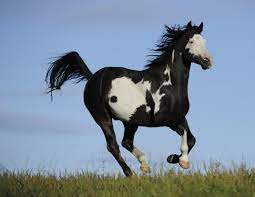

This is a: black.
Probability it's a black: 0.8747


In [34]:
predict("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYSFRgSEhUYGRgYGRoYGRgYGhkYGBkYGBoZGRkYGhgcIS4lHB4rHxwYJzgmKy8xNTU2HCQ7QDs0Py40NTEBDAwMEA8QHhISHjQrJCU0NDE0NDQ0NDQ0NDQxNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAMUA/wMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAAAQIDBAUGB//EAD0QAAEDAgMFBQYEBQQDAQAAAAEAAhEDIQQSMQVBUWFxBhMigZEHMqGxwfAUUoLRI0Jy4fFikqKyFjPSg//EABkBAQEBAQEBAAAAAAAAAAAAAAABAgMEBf/EACMRAQEAAgICAgMAAwAAAAAAAAABAhEDEiExE0EiMlEEUmH/2gAMAwEAAhEDEQA/AFAUgCGhPyr6DykATgEoCe1qgQBOASgJwCKA1OhLCUBAAJQEAJU2pAE6EIlTYchNlEpumjpSpiWUDkJJRKgdKJSJVQIQhXYEIQrtNBCEqIRJCchA2EkJyIQMISQnwkhNG2e1qcGpwCcArpDQ1ODU4BOAQ2QBKAnAJ2VF2bCE6Eoapo2YlhPDUuVTRsyEQpMqWE0u0cIhS5UZU0bRQlhSQjKmjaPKiFJlRlTRsyEsJ0JYTRsxCztuOcGF7HOaWePwtzmLyMuptNvkuZZ2ybUDWuysLiGP97IW73h0SARmsROilsl8rJb6dxCo7S2rTw+QVHeKo4NY0Xc4kgTyAkSVzI7VMz1AKjGgxDjmeDA1bA52FtFxu2Nour1e8D3uyEBjnCCIM2EmLrGXJJPC44W3y9laZ0UWHxLKmfI4OyPLHRue2Jb8QvL/APynFtLz3t3/AOlkC2WRA1A0vuXXezuhlwpcZ8dR7rzcQ1siddNVcOSZXUMsbjN11MIhKkXVy2IRCEIpISQnIQUQE8BI0J4QEJQEAJwCAATgEAJQgAE4BCVAAJYQnIEhEJyEDYSpUIGwlSoQIhKhAia4wJT1lbYxPdtkse8C/gGaN8uEWHOfJNpGF2gxVVxd3b2MAsTdxdp/LwuBYEkmIIC8/wBpUXsJNRrATfwubqbzkBt0IW5tTHh5cQ97ALgVPACSDGWmGEkAF2s6rnaj8xBME8mtaBzhoC8vLlK9GGOkFNpceS0dn4N9Z/dUmlzoJDREkDmSBv4qsBAXddj9iO7nv87mPqZgwtiWsFpg2Mm/kF57dOsb+zOweGFFgxDHPqOHjLXuAkmYEHdpK3fwfcgMF2tADTEWGkxaYV3AMLGBpJdbUxJ5kCwJRi6ktieR8rj6rfDnZlr+s8mM0oITkL3vKahOQgakT0FBSCcEAJQgUBKEAJyACckQ48wECzyUb8QGiTNuSzdo7UpUmlz6hPAAul2lgGxNyLmBfVec9oO0Dq8ta0Nb1cXEf1E26fNc8s5i1jjcnZ7W7b0qJLGNL3DcCIHUgwOmqg2H2676o2nWpBgeQ1r2uJAJ90OBGhMCRxXmSlw74PVcPmu3X48dPfULl+xG3jiGdzUM1KYFzq9mgd1Gh8jvXUr045TKbjhZq6pEJULQSEJUIEQlQgqYyoxvvPaw8S8MPkYK5vajGVhk/HZW/kGIYPU5JPQlbO1ccaILgyQBLnAgH1NvKV5ttvtQ/EHK2GsBtYF55k6dIFlyzyk9t442+mZtahSY9wpPdUv75II0vcDxXm4U2ysGH08RVcJ7tjA3+qo9rc3kA71We52Y/utXBVCzD1mDV7qQjkwvcTHUN9V47XokValGGOeXAZSBlPvHNwHDVavZba7aFcVKxe5obkbBMMBi8cAAs3FU/wCGfX0uqGGl7msaCXOIa0DUucYAHUqD3XBbfpPpioHwIuHWMTGbLrHNTPxTTEGQ644EdV41iqdbDuArsqMkAAuBAiIgHQ23ArVw223sY2nmeIgsewtsBuLXCHjdEjfrZTrcb4all9vT5Tll7BxZq0mucIdcOgyMwMLUXv48u2MteTPHrlqBCELoyEiVEIKjQnAJAnBQKAnAJAnBAAJlRoAJOgueQFyVIFnbfJ7h7GmHPhgMwRnsSDxy5kpHF9qtqy0O/OfAL2aLZj8QOUu/nEca2nIL3TrDQB7ztw6f2C3+1TM2K7lsQzIwbmjMA4ROlnAfpTO57v8AiaFgLGHQmoYzPjdllxA1lh0Onlz85O+PiMKuIGTLBB8ROpdpHIC9uvkxjTE2AG8wOe/UrU2bge+JIbNyWibDS7jEnWABcmeC3D2bfBIYWk2zPYGNANrFwkcA0NlZmFvlrtI5/ZmPfReytTMOYZ5Hi08iJHmvZNlbRZiaTatPRwuN7Xb2nmCvJMXsvJmNLM8M99wacjSLFud0FxBncOiho7Uq0WPp03uYHgZwOHI7iRw3LWOVwuqzljMvT0bbvbKjhiWMHevFiGmGNPBz735AHnC5mv2+xP8AIykOWVxjlOa65KlxiwEx8vihpkrOXLlVnHjHWN7f4neyj/tf/wDa0MH2+frVotc3eaZLXD9LpB9Quc2Z2ZxOK8VKk4tFi45Wt8i4ifJdGz2fYkUy7wB35JJMf1ARPISp82U+1+PH+NrDdtcI+Mz3sPB7HfNsj4q5V7SYQNLvxFPTQOl3+0eL4LzLaOAfhiGVqZYTOWd4Fp/yqbKRqOysEkzYcACSfIAnyW5z5M/FGn2k2hSxDvA6rUMzmecrAP8ASzX1AWC2hKsPpcNVHcFcssu123JqabXZfY7q9drWNnKC9x3NDZInq4AeabtTBdxVfSkeEjykAgH1SYXadWix4pPyio0Ned9jNjqP7p3aKuXYk1XCO9ZSqRwz02g/EFY+2kFQiL/5U/Y7AB+NpEXa1znmd2RpI/5QqVd/hC6j2e0wcS9zRZtMyebnNt8CunHN5RjK6xr0GowOBa4Ag6ggEHyK4PH9ka34h34cMFF7swl2XJPvNygcZiOS79C9eWEy9uGOVnpQ2Rs4UGZIAJicpJExuJueqvJULWOMxmozbbd0iEqFoIhKkQVk4JgclzLOw8JwCYCllNmjlBi8MKjYOoILTvaQdRz3eamlQV3EiA3NynLPKeClrUjzraz2HH5neNjnMe+BmjKMuW2oDcsjmVX2fgn4+t3TPcaS+o4+Egue6eZJ09V3VPZ/eV3Oquu2myGUyWNaHOqAguHjdpxAPDRXMBsqlh3TRptYXCDlESOq49ba32TYHZzKDAymxrQOAjznem4jZ/eWe92XeBYuB1GYy5o6GSrspQurLne1dRmFwznMY0OMMZYeEu3gbiGg/BeRzN16B7UcSR3NPcc7z5ZQPr6rz5q83Ld5OuE1Fin7rvIfGfoptnsl7ZFswJ6A3+Cga7wkcx9V1fYXZfe1muLZDYN4i17g6iy5Wukew0mjKMoDRwFtb6eatNKrYdwIsQY1gzCsBcmmB2p7N08cyHANeB4KgElvI8RyWPgeyFKgw02E53DK6q4S4tdGdrRo0ESLcV244KniaP8AMN11d2DnO0uwMOMM97KbGd2C8ZQG5iAbE6xeY3ryarS0AEnQDeTwXb9oNvVO/rYUuim/IzoS0eLkJN+in2L2WdT7ytWZmexk02C/jyyHcyPmtTwjK2ZUwWHY6nimOqPJGZrfcaBq2d5BueYCyO1W0WYuq2tTYWeHI4HSGOIYR+kgEclJX2PWoU21a7Wta8kBrnDPxzZNY3z0VB9MbtJ+K0irXacoXcezSlau/iWN/wC5+oXG4htgPvVdx7NneCsN4cw+od+y6cX7Rjk/V2aEqF7XmJCISoQJCROSIEQlQgqgJ0JAU8LO1oASwgJQEQAJcqAE6EFcUv4hfuyBvnmJP09VPlToRCoQBOCIRCg889qlEzh3xaHtJ5y1wHz9F581e3dpdjjGUHUrBw8bHHc5sxPIyQeq8Uq0nMc5jhlc0lrmnUOBgg+a83LjrLb0YXc0c3UfFdJ2bfWqtrMw7iHCibNOUkkhog8YLlzTHK9szGvwtdtRh19HNdq0+cLjXR33s42XiaNd7qrHsYWEHMYBdNiG7zz/AHXpjXLmth7ZZXYHAwd4OoP1W7Tqg6rnfarM3THCLqOpXDGlzjYD7A5rx/tJ2xr4pxptcKbAXCGOJzibEuMcJERqmtqrduqbqeMqzMPIc2d4IAIHIQvRey21jicMysPE9rSx40l7BvnSRBnmuFxWzqFTAfiq1QiuGlrCXF2fKSWtLelpW52MrsobLqVHvDM7qpBm5MBjQALkktgLevCOI23j31q76lR0uc46Eloi2Vo/LZRYar4HSVWrNA1N/kow+GRxPyVRM+tLfNdZ7NMTFarSJ99geOrHQfg74LiTous9muGLsU5/8rKbpPN5AaPg70XTj/aM5frXqKE5C9jymoTk1AIQhAQhCEGc16eHqs1SArLe04enh6gaU4OQTh6eHquHJ4chqLAclDlAClBTaaWJShQBycHJs0lXnXtI2DB/G0xYw2qB6Nf8mn9PNehByZXpNqMcx7Q5rwWuB0IIghTPGZTS4243bwRrJ0TnU5YbGW38t66Db/Z12CqCfFSeSGP+OV43OA8jEjgKVaGNMtjMIkSvFZZdV6ZqzcTbM2nUwdQ062ZjmmCD9dxHMar0PZPaBlWAHjNw0PotbZdRtajSq5QS+mx0kCbtEj5rzj2h7MGFrMrUBkZUBlrLNa9kSQBYSCDHEFbz4tTcc5nu6Xe23aZ7nHDMLmgWeCGFr7/ymCR68bBcU0qsa5Jk3JuTxPFbOC2Hiq9MVadBz2OmHNc2+UkHwkzqDuWJjfp03GbWecpbNtY56W9VOzEOdTYwuORgIDd1yXT1lxUmM2PiWeF+Hqg/0OI9QCFHS2TiT4W4esf/AM3/ALK9am4hquBKhIWv/wCMYyC78NUtyE+QmT5LJq0yxxa9rmuFi1wIIPAg3CtlhuAHz0svX+wuBp08Kx9My6p43nfnFizo2IHrvXkdGgXDML8hqvR/ZtjQW1KBOmV7RyIyu+Ib6rfFZMmM/wBXbpUIXqeciEqECISpE2BCIQmxnd2ju1IE4KKiDEZCpwlCCIMShimCWEEORKGlTQnAIbQgFOEqUBLCGzAlhSIQ2y9vbMGKoPonVwlh/K9t2H1+BK8mY/Mw06lniRB1DmmCOv7L21eOdtsB3WNqRZtQio2OLwC+f1Zlx5sfVdePL6d72BxZqYUU3e9Sc5h/p99vwdH6Vh+1iv4cPT4ue7/aGgfMp/s6xQD6tInxOYx455JDv+wWJ29xXf4stJhlJuQcS4eJ5jqY/SpcvwJj+Tmdk4F2JrU6DDBe4NnWBqTG+ACfJe8YHCNoU2UmCGsaGt4wN55nXzXlfs6wwONa6ZyMqOA3iwYD/wAyvXFeGeNpyW70EIQuzmFh7f7L0MZDqgLHiwqMgOI4OBs4db81uIUsl9rLr08W2lsSvhandFpzE+BzQcrxIDXA9S0EHSRyJ2MfWbszaLHNnu8jS8cGVAQ4ADhAPUL0faDMzACP5gR1FwfgvOfaThi7GAwf/Sz4OeP2Xly/HLUd8b2x8vTqbw9oc0gtcAQRcEG4IO8Jy5H2d1HmjUY6cjKgazgJaHOaOVwf1FdcvVje024ZTV0EIQqyRCVCBEJUIM8FKCmNTmlGkgTpTAlBvCIeE4JENKB6UJh4J4KATgEgShAqVNlIXXQOJXnXtHwpbUZWjwloAO7MwuJafIgjzXoLnj5KHFUmVGOpvaHMcIc06ELGePaabxurt5FsvFZK1Ks0lgD2Z4Nw3MM3kWyPNdp2t7Hmu5+Jwzv4pglhIDXkWlrj7riAOR5TK5Da+ynYHEBh8VNzg+m4iZbIkHm2YPkd69P2NtRlamwjUeBw3hzRfyMSuOP3jXXL/aPOeyLalPGE5e7c1rm1GuBETFiNbkA/YXqmHrh4trvH3uVfF4RlSXAAPiM0ajcHHhwO74LN2Qx73va85Mjo58fSCs3LLjy8+iSZT/rflKoqoiLzpfinkr0Y5bm3KzRyFXr4ptNjqjzDWAuceAaJPwXAbV7bYjK6pTyUwXBjGloe7SXOcTaQI3R4vNS5zH2sxtd5i8U2m+n3lmuc4AnTNlsPTN6LlPaJhvxNfCsw/wD7X52/6cgyuzO5NufVP7KbRr7ULTV7ptOk+Xho8b3wcsAk5WiQZ3kLssXgWMqiqBLshYCdzSczo6w30C4XWXI6TeOKnsjZzMNSbSYSQ3Vx1c43c49T6WCvJjHJwcvVPEcKVIkziSOCCd3mm0KEILkgcqFQmB9yPvQJcyDJo1ptv4KbmFzGI2k1kAE+JoIcNRJEGOk+i0G7WEhryLPAcRwgu+g9Vy+TFvpW2Hb/ALuinvPksirtIAloN87svkDf/cnM2iHPLQ7Uta39Ul56gDykJ8mOzrWw50CUNdeN8LNxWPY1kg3G4R/KM48oCmpV7+FwNp3XPDysr3m061dadSpWiAstuPaQL3BEjf4pgesK47EQ6BeWF3oR9CfRWZQ6rIKCqDMYGgydXEj+nNHwS1sa0FpkQTx3EuZKneLMauuECfvkkcyCFk1NpAh2S4Ia5v6gbeTgPVOftlsE6RlIO6HX9Yn0Wflx37OtaGIaIImLazEJzaYgQq7cYwMMv6xqCQSBbkpDigHZCIME/fktd4aqlt/YjcXRdSdZw8THfleBY9DoeRXnGxNrPwOIyVgcodkqNPvNgkZhxi/UExqvUX4xoY5/5bTzMx03Lhu3eBaXsxjR4XNDKobqHiAxx5lpif8AQFyzyl8z3G8ZfVd5hntqNz0yC2xDhcEEAyCqeNoMZUZUz5S6Q5swHhogE8wSFzPY/HOp0zTmWNOcc2OI8I4HUx1C6LHPY5ofJkZntjhng68eHJYz5JnhZ9tY49cpatirmLWyJEwAZJ1+V1IyoSTwHxKxWF7nMeXNs+L2dBB1bxiVoU8W1pdJ3j0cRu+96nDnZjrIzxnbcSlgqNeyoJY6WOG6CIjzkrlcZ2BpPgCvUaA45WkMdGaJvbgLngt0Y3IwXnMSD+mJKp0cc4vzGS3QTFgIMW6BXLmx8bSY5fSHZ+yG7PcGszlj4zPJ8TX31gAAEZY6HlO6zFufUa0vkZbfC6qv2ie8e2xa6xNjaBePvRNqYtjD/DDGjN4soAMDSw5/Vc/x79pfTp2vXrY2GOkNPEx8/wBk0vh7R+Zp9R/b5LJrbSgGmLEZSDukgTHlPqrj8cwsFQXLbgcQ0eIdYcu85sb6vpx6WHVK/jIaRxE9L/RGDxTiMxENEAW66HeLhZbsdNxqWkcIdMy0/HzKKe0coLTrEgaza5nhK5znm97b+Pw6FzwRI3hQ0K8eE7pHyj6rDO0CWeHUOBA5b/ilxWM94zZ8RyjKSrf8jH3E+KtOhjcz8t9T6AA+SvNeN5Gp+H2VxrcW6mS5h1NtNSIspsTtMEgtMgANPWJmeMkz0Sf5M1svF5cn3h3nQ281I+sSZm/vA9Jj75Kl3u77+9VIx4MW1ny+/ovNdusWxiiS0GRMkHjc3B4305K1+LMgtsWRF9CARPwWQTmERvE8onTrKtd8GmDv+B3fRS7JVh9WwAJsB9BHorNDHOBhpiQfSRPrlWWyoJPL/H30Ti+b3A+msLPmLuVfNYk6ibHnIhXqu1C/KWy1wbE8Re3T+/FZDX6ED3Qb9AIQXTlIFm68Zk25i6TPKTWyyNN2KcQGOPhEjXiQfnuTWYp0Fu4ZTe8XJ/f1KrNiYJ/tOn0UZqGYESdRugLPfKnhf70gzPLykH91E98aaEi39I8PwlQd9B36CN+79k6uDEjd9ypLT6W/xDiHCbOjyLRlaZ6WUgquzEm511PGwuqL3EizTu3/AHvun1p4aiJ5xw9EueX9PDQfi35DT4uDnHjAbA9WqGu/M3KTLeG477jyVd9QgE7xu36KPNBmSRAaR1iHdbqdsv6aWsO3KDlsCdOqlNfMGtJ0Ejjqbesqox0GOgPTWyRtLX8wbrNtZiFnyu1h7nZRDjIIPA239UjsW45jJuAJvJAjjzAUDHknzUz3R4SOcqzKzwiwyuXAXvN/O0/NQVamQGEym2NdZsnOqeIm25Td2CjXnMHGbXJ53+p9UueBfTnrZVK4tmEnxfduCe+qCJSm9JnYiYeOP9k+pWJaBoZ14cfVVqbrbgn94JygzvE7+iedmy1KuYNaeMxzFwpCZOYEgxbh6LNeCXWkZbm8qQVC33p5W4ppOzQz3idOqYK0EM4iSemhUNWvbdJUeIqRlfa9iR8kkXse8S4X3eqhygZW2IiTrqbpXV5i3IJQ8CfLyVN7c5UdI6qSjWIjn9EiF6vpg8P/AGQX2Lt4CEKKnpOzBpI118lJVqTeNYt0SoWb7VLT0+9/+EjXkOI3ftKELmqd+7mJUTTdvOJ89UISC5UABgDcfgoqLyQZ+96EKLFmgJdw3qSq6Gutv+oQhc6hKdyDxlJpI4n6IQiog7QxqApSZEJUKsVGTad8pe9ztaSBP7JEIsOplSVr+iEKVYp1XlthoU0mQhC1PSUOsQOKZVEX5oQgkiIPFTlgJI4XQhKIK+kqKmY3ckIV+khS6DEKxhruM8EISq//2Q==")

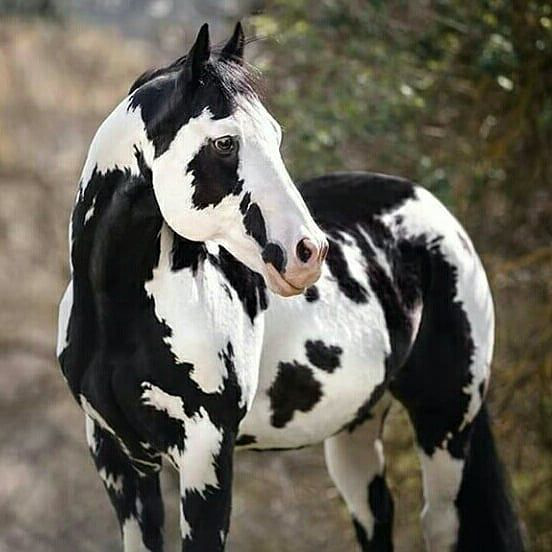

This is a: paint.
Probability it's a paint: 0.9842


In [36]:
predict("https://i.pinimg.com/originals/9b/64/eb/9b64eb328c1dc47b0d7e2447a8c407ea.jpg")

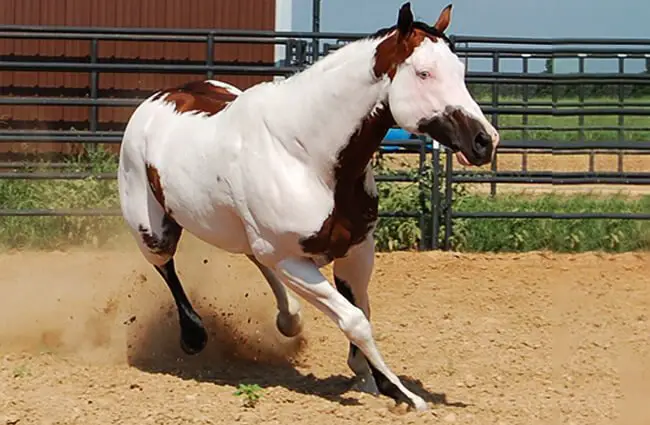

This is a: paint.
Probability it's a paint: 0.9054


In [37]:
predict("https://animals.net/wp-content/uploads/2020/03/Paint-Horse-3-650x425.jpg")

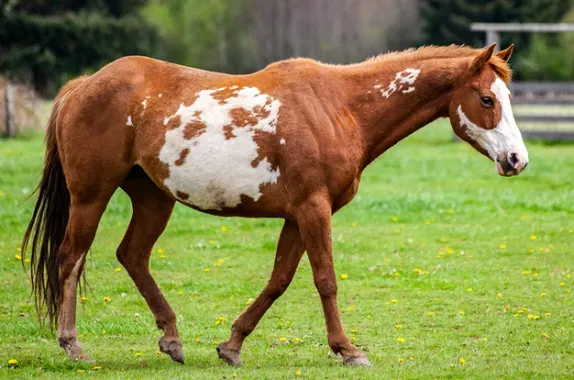

This is a: flaxen chestnut.
Probability it's a flaxen chestnut: 0.7263


In [38]:
predict("https://horseyhooves.com/wp-content/uploads/2022/08/Overo-colored-Paint-horse-walking-in-a-grassy-field.jpg")

In [39]:
learn.export('horse_colors.pkl')

In [40]:
learn.dls.vocab

['black', 'blood bay', 'buttermilk buckskin', 'dapply gray', 'dark bay', 'dun', 'flaxen chestnut', 'fleabitten gray', 'liver chestnut', 'paint']

In [47]:
labels = learn.dls.vocab
def gradio_predict(url):
    temp_img = "predict_temp" + os.path.splitext(url)[1]
    download_url(url, temp_img)
    im = PILImage.create(temp_img)    
    pred,pred_idx,probs = learn.predict(im)
    return ({labels[i]: float(probs[i]) for i in range(len(labels))}, im)

import gradio as gr
gr.Interface(title="Horse Color Classifier",
             fn=gradio_predict, 
             inputs=gr.inputs.Textbox(label="Image URL"), 
             outputs=[
                 gr.outputs.Label(num_top_classes=3),
                 gr.outputs.Image(type='pil')
             ]).launch(share=True)

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://f05d137c5679945ebe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [42]:
# !pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 65.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 7.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=a221638a443b7664f78dd2e1fdd0fad7f3e9a749d1c3c8804b7c373a6d0e3888
  Stored in directory: /root/.cache/pip/wheels/c0/96/80/1aeaaf27265398a7393b296714b84e51a7d00101f8a665a25a
Successfully built ffmpy


In [48]:
1+1

2